<a href="https://colab.research.google.com/github/merazAfridi/Retina-blood-vessel-segmentation/blob/main/TERNAUSNET_retina_blood_vessel_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/retinabloodvessel/Data/test/mask/11.png
/kaggle/input/retinabloodvessel/Data/test/mask/4.png
/kaggle/input/retinabloodvessel/Data/test/mask/9.png
/kaggle/input/retinabloodvessel/Data/test/mask/14.png
/kaggle/input/retinabloodvessel/Data/test/mask/1.png
/kaggle/input/retinabloodvessel/Data/test/mask/2.png
/kaggle/input/retinabloodvessel/Data/test/mask/10.png
/kaggle/input/retinabloodvessel/Data/test/mask/18.png
/kaggle/input/retinabloodvessel/Data/test/mask/12.png
/kaggle/input/retinabloodvessel/Data/test/mask/7.png
/kaggle/input/retinabloodvessel/Data/test/mask/17.png
/kaggle/input/retinabloodvessel/Data/test/mask/5.png
/kaggle/input/retinabloodvessel/Data/test/mask/3.png
/kaggle/input/retinabloodvessel/Data/test/mask/16.png
/kaggle/input/retinabloodvessel/Data/test/mask/8.png
/kaggle/input/retinabloodvessel/Data/test/mask/6.png
/kaggle/input/retinabloodvessel/Data/test/mask/15.png
/kaggle/input/retinabloodvessel/Data/test/mask/13.png
/kaggle/input/retinabloodvessel/Data/

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from skimage.transform import resize
from skimage.io import imread, imshow
from tensorflow import keras

2024-10-21 21:17:32.002549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 21:17:32.025654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 21:17:32.032664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
#paths for training and test sets
train_data_path = '/kaggle/input/retinabloodvessel/Data/train/image/'
train_mask_dir = '/kaggle/input/retinabloodvessel/Data/train/mask/'

test_image_dir = '/kaggle/input/retinabloodvessel/Data/test/image/'
test_mask_dir = '/kaggle/input/retinabloodvessel/Data/test/mask/'

Shape of training data: (80, 256, 256, 3)
Data type of training images: uint8


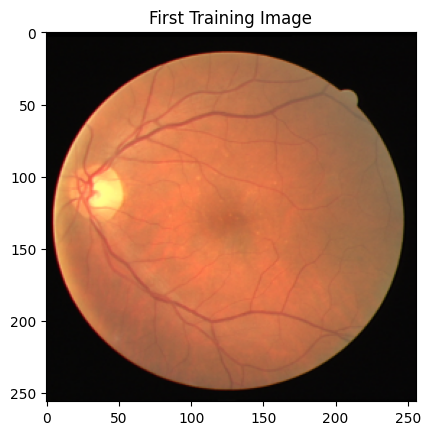

In [ ]:
#Img dimension
row = 256
columns = 256

#define paths
train_image_dir = '/kaggle/input/retinabloodvessel/Data/train/image/'
train_mask_dir = '/kaggle/input/retinabloodvessel/Data/train/mask/'
test_image_dir = '/kaggle/input/retinabloodvessel/Data/test/image/'
test_mask_dir = '/kaggle/input/retinabloodvessel/Data/test/mask/'

#list of training img
training_images = os.listdir(train_image_dir)
training_images.sort()

#array for training img
X = np.zeros((len(training_images), row, columns, 3), dtype=np.uint8)

#load images, and resize
index = 0
for x in training_images:
    path = os.path.join(train_image_dir, x)
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)
    X[index] = image
    index += 1

#print shape and datatype
print("Shape of training data:", X.shape)
print("Data type of training images:", X.dtype)

#visualize 1st img
plt.imshow(X[0])
plt.title('First Training Image')
plt.show()

# **MASK**

Shape of mask data: (80, 256, 256, 1)
Data type of mask images: uint8


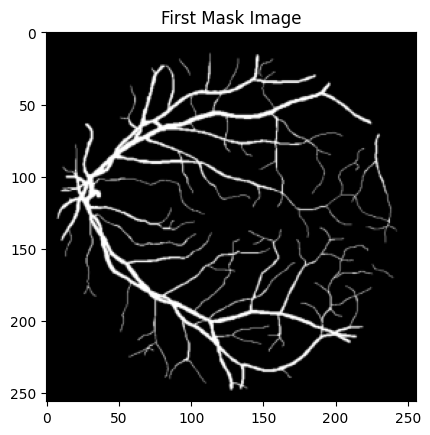

In [ ]:
#Mask Training

#img dimensions
row = 256
columns = 256

#define paths for training masks
train_mask_dir = '/kaggle/input/retinabloodvessel/Data/train/mask/'

# list of training mask images
training_masks = os.listdir(train_mask_dir)
training_masks.sort()

#array for  training mask images
y = np.zeros((len(training_masks), row, columns, 1), dtype=np.uint8)

#load mask and resize
index = 0
for x in training_masks:
    path = os.path.join(train_mask_dir, x)  # Use 'train_mask_dir'
    image = imread(path)
    image = resize(image, (row, columns), mode='constant', preserve_range=True)

    #reshape image to have a single channel
    if len(image.shape) == 2:  #if the image is grayscale
        image = np.expand_dims(image, axis=-1)  #add the channel dimension

    y[index] = image
    index += 1

#print shape, datatype of training masks
print("Shape of mask data:", y.shape)
print("Data type of mask images:", y.dtype)

#visualizefirst mask
plt.imshow(y[0].squeeze(), cmap='gray')
plt.title('First Mask Image')
plt.show()


# **Augmentation**

In [ ]:
import albumentations as A

# Define transformations using albumentations
transform = A.Compose([
    # A.RandomCrop(width=512, height=512),  # Uncomment if you want random cropping
    A.HorizontalFlip(p=0.5),                # 50% chance to apply horizontal flip
    # A.VerticalFlip(p=0.5),                # Uncomment for vertical flip with 50% probability
    # A.RandomRotate90(p=0.5),              # Uncomment for random 90-degree rotation
    A.RandomBrightnessContrast(p=0.5),      # Randomly change brightness and contrast with 50% chance
    A.Blur(blur_limit=7, p=0.5),            # Apply blur with a limit of 7 with 50% probability
    A.ColorJitter(brightness=0.5, contrast=0.5,
                  saturation=0.5, hue=0.5, p=0.5),  # Color jitter with 50% probability
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5)  # Add Gaussian noise with 50% probability
])


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import albumentations as A
from tqdm import tqdm

# Define the augmentation transform
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(blur_limit=7, p=0.5),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5)
])

# Initialize arrays for augmented images and masks
aug_x_train = np.zeros_like(X)
aug_y_train = np.zeros_like(y)

# Loop over the dataset and apply augmentation
for i in tqdm(range(len(X))):
    # Apply the augmentation
    augmented = transform(image=X[i], mask=y[i])

    # Store the augmented image and mask
    aug_x_train[i] = augmented['image']
    aug_y_train[i] = augmented['mask']

# Print the shape of augmented images and masks
print(aug_x_train.shape)
print(aug_y_train.shape)


100%|██████████| 80/80 [00:00<00:00, 207.55it/s]

(80, 256, 256, 3)
(80, 256, 256, 1)


In [ ]:
import os
import cv2
from tqdm import tqdm

#create directories for save augmented images and masks
os.makedirs('augmented_images', exist_ok=True)
os.makedirs('augmented_masks', exist_ok=True)


for i in tqdm(range(len(aug_x_train))):
    #augmented image and mask
    aug_image = aug_x_train[i]
    aug_mask = aug_y_train[i]

    # Save
    img_filename = f"augmented_images/img_{i}.png"
    mask_filename = f"augmented_masks/mask_{i}.png"

    cv2.imwrite(img_filename, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_filename, aug_mask)
print("Augmented images and masks have been saved in the current working directory.")


100%|██████████| 80/80 [00:00<00:00, 229.34it/s]

Augmented images and masks have been saved in the current working directory.


In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize

# Define dimensions
row, columns = 256, 256

# Original training images directory
train_data_path = '/kaggle/input/retinabloodvessel/Data/train/image/'
training_images = os.listdir(train_data_path)
training_images.sort()

# Augmented images directory (adjust the path as needed)
augmented_images_dir = './augmented_images/'
augmented_images = os.listdir(augmented_images_dir)
augmented_images.sort()

# Initialize total_x_train with the correct shape
total_x_train = np.zeros((len(training_images) + len(augmented_images), row, columns, 3), dtype=np.uint8)

# Load original training images
c = 0  # Counter for original images
for x in training_images:
    img = imread(os.path.join(train_data_path, x))
    img = resize(img, (row, columns), mode='constant', preserve_range=True)
    total_x_train[c] = img
    c += 1

# Load augmented images
d = 0  # Counter for augmented images
for x in augmented_images:
    img = imread(os.path.join(augmented_images_dir, x))
    img = resize(img, (row, columns), mode='constant', preserve_range=True)
    total_x_train[c] = img
    c += 1
    d += 1

print(f"Total training images shape: {total_x_train.shape}")


Total training images shape: (160, 256, 256, 3)


In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize

# Define dimensions
row, columns = 256, 256

# Original training masks directory
mask_data_path = '/kaggle/input/retinabloodvessel/Data/train/mask/'
training_masks = os.listdir(mask_data_path)
training_masks.sort()

#augmented masks directory
augmented_masks_dir = './augmented_masks/'
augmented_masks = os.listdir(augmented_masks_dir)
augmented_masks.sort()


total_y_train = np.zeros((len(training_masks) + len(augmented_masks), row, columns), dtype=np.uint8)

#load original training masks
c = 0
for x in training_masks:
    img = imread(os.path.join(mask_data_path, x))
    img = resize(img, (row, columns), mode='constant', preserve_range=True)
    total_y_train[c] = img
    c += 1

# Load augmented masks
for x in augmented_masks:
    img = imread(os.path.join(augmented_masks_dir, x))
    img = resize(img, (row, columns), mode='constant', preserve_range=True)
    total_y_train[c] = img
    c += 1

print(f"Total training masks shape: {total_y_train.shape}")


Total training masks shape: (160, 256, 256)


In [ ]:
#IMPORTANT
# Convert masks to boolean type
total_y_train = total_y_train.astype('bool')
print(total_y_train.dtype)'

bool


# **X TEST**

(20, 256, 256, 3)
<class 'numpy.ndarray'>
uint8


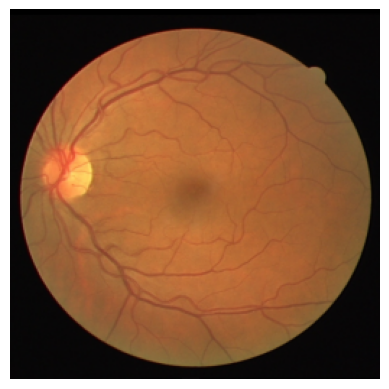

In [ ]:
# Define dimensions
row, columns = 256, 256

# Test data path
test_data_path = '/kaggle/input/retinabloodvessel/Data/test/image'

# Load test images
images = os.listdir(test_data_path)
images.sort()


# Filter only valid image files (you can adjust the extensions based on your dataset)
valid_image_extensions = ('.png', '.jpg', '.jpeg', '.tiff')
testing_images = [img for img in images if img.endswith(valid_image_extensions)]

# Initialize x_test array
x_test = np.zeros((len(testing_images), row, columns, 3), dtype=np.uint8)

# Load images for prediction
index = 0
for x in testing_images:
    path = os.path.join(test_data_path, x)
    try:
        image = imread(path)
        image = resize(image, (row, columns), mode='constant', preserve_range=True)

        # Store the image in x_test
        x_test[index] = image
        index += 1
    except Exception as e:
        print(f"Error loading image {x}: {e}")


print(x_test.shape)
print(type(x_test))  # numpy array
print(x_test.dtype)  # uint8



# Display the first image
plt.imshow(x_test[0])
plt.axis('off')  # Hide axes
plt.show()

# **Y TEST**

y_test shape: (20, 256, 256, 1)
y_test type: <class 'numpy.ndarray'>
y_test dtype: float32


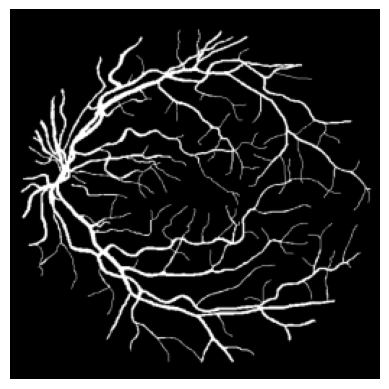

In [ ]:
# Directory for test masks
test_mask_data_path = '/kaggle/input/retinabloodvessel/Data/test/mask'

# Load test masks
mask_images = os.listdir(test_mask_data_path)
mask_images.sort()


valid_mask_extensions = ('.png', '.jpg', '.jpeg', '.tiff')
testing_masks = [mask for mask in mask_images if mask.endswith(valid_mask_extensions)]


y_test = np.zeros((len(testing_masks), row, columns, 1), dtype=np.float32)

#load masks for ground truth
index = 0
for mask in testing_masks:
    path = os.path.join(test_mask_data_path, mask)
    try:
        mask_image = imread(path)
        mask_image = resize(mask_image, (row, columns), mode='constant', preserve_range=True)

        #check if mask_image is single-channel and reshape if necessary
        if mask_image.ndim == 2:
            mask_image = mask_image[:, :, np.newaxis]  # Add a new axis to make it (height, width, 1)

        # Store the mask in y_test
        y_test[index] = mask_image
        index += 1
    except Exception as e:
        print(f"Error loading mask {mask}: {e}")

# Print the shape and type of y_test
print("y_test shape:", y_test.shape)
print("y_test type:", type(y_test))  #numpy array
print("y_test dtype:", y_test.dtype)  # float32

# Display the first mask
plt.imshow(y_test[0].squeeze(), cmap='gray')
plt.axis('off')  # Hide axes
plt.show()


# **VISUALIZE**

In [ ]:
# Reshape total_y_train to add an extra channel dimension
total_y_train = total_y_train[..., np.newaxis]  # Add a new axis to the end


print("Total Masks (total_y_train) shape:", total_y_train.shape)

Total Masks (total_y_train) shape: (160, 256, 256, 1)


In [ ]:
# Print shapes and sizes of the augmented data
print("Augmented Images (aug_x_train) shape:", aug_x_train.shape)
print("Augmented Masks (aug_y_train) shape:", aug_y_train.shape)

# Print shapes and sizes of the total data
print("Total Images (total_x_train) shape:", total_x_train.shape)
print("Total Masks (total_y_train) shape:", total_y_train.shape)

# Print shapes and sizes of the test data
print("Test Images (x_test) shape:", x_test.shape)
print("Test Masks (y_test) shape:", y_test.shape)


Augmented Images (aug_x_train) shape: (80, 256, 256, 3)
Augmented Masks (aug_y_train) shape: (80, 256, 256, 1)
Total Images (total_x_train) shape: (160, 256, 256, 3)
Total Masks (total_y_train) shape: (160, 256, 256, 1)
Test Images (x_test) shape: (20, 256, 256, 3)
Test Masks (y_test) shape: (20, 256, 256, 1)


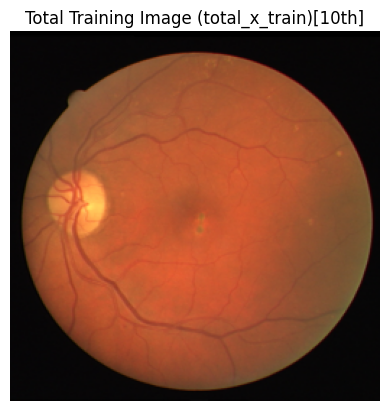

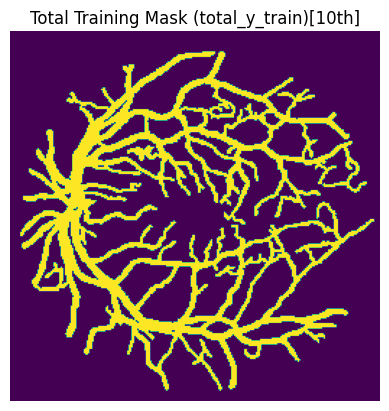

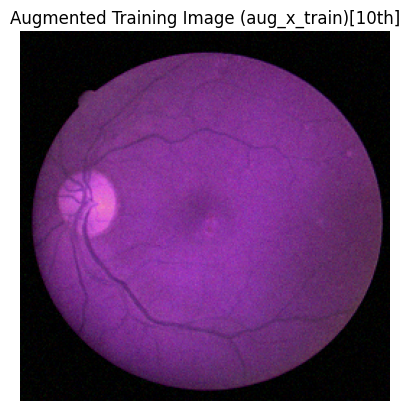

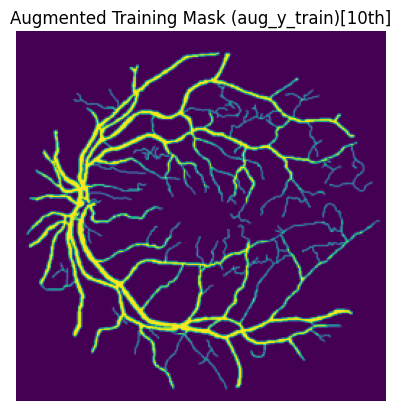

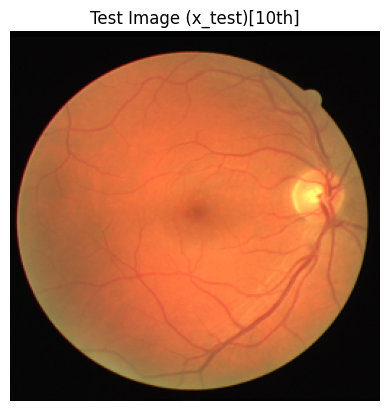

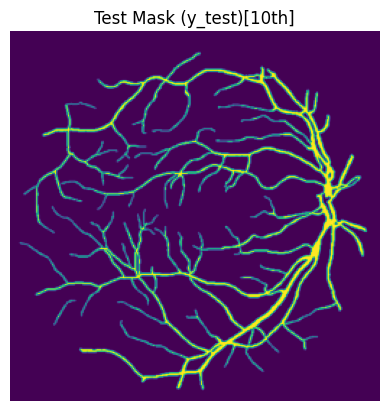

In [ ]:
import matplotlib.pyplot as plt

# Function to display an image
def display_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()

# Display the 10th images from each dataset
index = 9  # 10th image (0-based index)

#Print Total Training Image
display_image(total_x_train[index], "Total Training Image (total_x_train)[10th]")

#Print Total Training Mask
display_image(total_y_train[index], "Total Training Mask (total_y_train)[10th]")

#print Augmented Training Image
display_image(aug_x_train[index], "Augmented Training Image (aug_x_train)[10th]")

#print Augmented Training Mask
display_image(aug_y_train[index], "Augmented Training Mask (aug_y_train)[10th]")

#print Test Image
display_image(x_test[index], "Test Image (x_test)[10th]")

#print Test Mask
display_image(y_test[index], "Test Mask (y_test)[10th]")


# **Metrics for training + validation**

In [ ]:
#Dice co, iou

#y_true = y_test
#y_pred = test_preds
#def dice_coef(y_true, y_pred, smooth=1):
#    y_true_f = K.flatten(y_true)
#    y_pred_f = K.flatten(y_pred)
#    intersection = K.sum(y_true_f * y_pred_f)
#    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


#def dice_coef_loss(y_true, y_pred):
#    return -dice_coef(y_true, y_pred)


#hi = y_test / 255
#hi = K.flatten(hi)
#hi = tf.convert_to_tensor(hi, dtype=None)
#pred = test_preds
#pred = K.flatten(pred)
#pred = tf.convert_to_tensor(test_preds, dtype=None)

def dice_coef(a, b):
          #  hi = K.hi
          #  hi = hi / 255

          #    hi = tf.convert_to_tensor(hi, dtype=None)
          #    pred = tf.convert_to_tensor(test_preds, dtype=None)
    hi = a
  #  hi = tf.dtypes.cast(hi, tf.float32)
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    upper_part = 2 * K.sum((hi * pred))
    lower_part = K.sum(hi + pred)
    dice = upper_part / lower_part
    return dice

def dice_coef_loss(a, b):
    loss = 1 - dice_coef(a, b)
    return loss

def jaccard_index(a, b):
    hi = a
    pred = b
    hi = K.flatten(hi)
    pred = K.flatten(pred)
    numerator = K.sum(hi * pred)
    denominator = K.sum((hi + pred) - (hi * pred))
    iou = numerator / denominator
    return iou

# **TERNAUSNET**

# **Training**

In [ ]:

pip install --upgrade tensorflow



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#TERNAUSNET

import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def ternausnet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    #encoder = Pre-trained VGG16
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Use layers from VGG16
    c1 = vgg16.get_layer('block1_conv2').output
    c2 = vgg16.get_layer('block2_conv2').output
    c3 = vgg16.get_layer('block3_conv3').output
    c4 = vgg16.get_layer('block4_conv3').output

    # Bottleneck
    bottleneck = vgg16.get_layer('block5_conv3').output

    #decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

#input shape for RGB images
input_shape = (256, 256, 3)
model = ternausnet_model(input_shape)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,854,657 (98.63 MB)

 Trainable params: 25,854,657 (98.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', dice_coef, jaccard_index])

# Callbacks
filepath = "/kaggle/working/model.keras"  # Save model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

callbacks_list = [earlystopper, checkpoint, reduce_lr]

# Clear previous session
K.clear_session()

# Convert to correct data types
total_x_train = total_x_train.astype(np.float32)  # Ensure float32 type
total_y_train = total_y_train.astype(np.float32)  # Ensure float32 type

# Normalize images
total_x_train /= 255.0

# Check shapes and reshape if necessary
if total_x_train.ndim != 4 or total_x_train.shape[1:] != (256, 256, 3):
    raise ValueError(f"total_x_train must have shape (num_samples, 256, 256, 3), but got shape {total_x_train.shape}")

if total_y_train.ndim != 4 or total_y_train.shape[1:] != (256, 256, 1):
    raise ValueError(f"total_y_train must have shape (num_samples, 256, 256, 1), but got shape {total_y_train.shape}")

# Print shapes
print(f"total_x_train shape: {total_x_train.shape}")
print(f"total_y_train shape: {total_y_train.shape}")

# Fit model
history = model.fit(total_x_train, total_y_train, validation_split=0.2, batch_size=32, epochs=10, callbacks=callbacks_list)

total_x_train shape: (160, 256, 256, 3)
total_y_train shape: (160, 256, 256, 1)
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5598 - dice_coef: 0.1864 - jaccard_index: 0.1117 - loss: 1.3070 
Epoch 1: val_loss improved from inf to 0.78768, saving model to /kaggle/working/model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 70s 16s/step - accuracy: 0.5839 - dice_coef: 0.1728 - jaccard_index: 0.1031 - loss: 1.2879 - val_accuracy: 0.5255 - val_dice_coef: 0.3083 - val_jaccard_index: 0.1822 - val_loss: 0.7877 - learning_rate: 0.0010
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6425 - dice_coef: 0.2555 - jaccard_index: 0.1476 - loss: 0.6924 
Epoch 2: val_loss improved from 0.78768 to 0.50946, saving model to /kaggle/working/model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 16s/step - accuracy: 0.6581 - dice_coef: 0.2499 - jaccard_index: 0.1439 - loss: 0.6764 - val_accuracy: 0.7878 - val_dice_coef: 0.2249 - val_jaccard_index: 0.1267 - val_loss: 0.5095 - learning_rate: 0.0010
Epoch 3/10

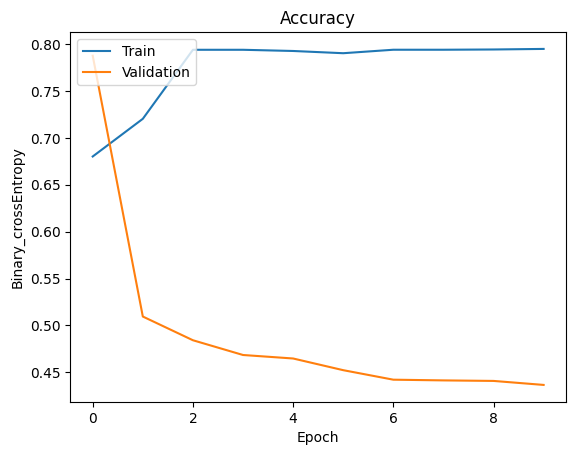

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

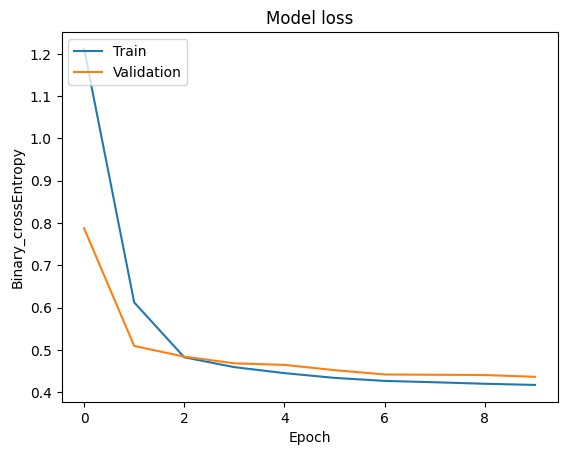

In [ ]:
#MODEL LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Binary_crossEntropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

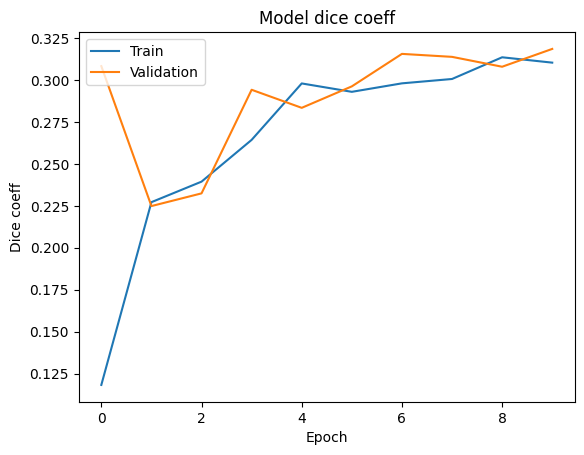

In [ ]:
#MODEL DICE COEF
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

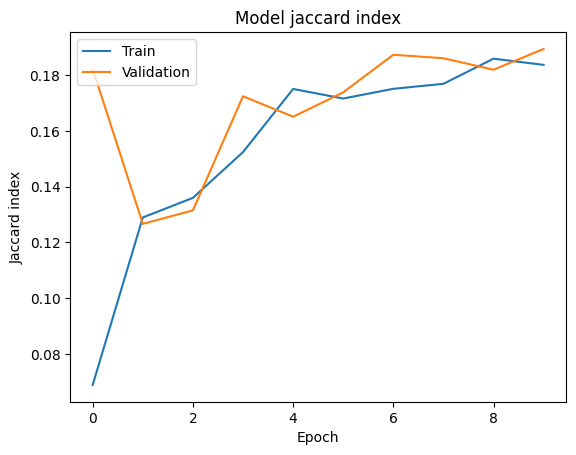

In [ ]:
#MODEL JACCARD INDEX
plt.plot(history.history['jaccard_index'])
plt.plot(history.history['val_jaccard_index'])
plt.title('Model jaccard index')
plt.ylabel('Jaccard index')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate
results = model.evaluate(x_test, y_test, verbose=1)
accuracy = results[1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6297 - dice_coef: 0.2057 - jaccard_index: 0.1146 - loss: 438.6545


In [ ]:
# Print acc

print(f"Test Accuracy: {accuracy}")



Test Accuracy: 0.6297019720077515
